## Analysing model training

In [92]:
from importlib import reload
import util
import model
reload(util)
reload(model)

<module 'model' from '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/src/model/model.py'>

In [95]:
import torch
import numpy as np
import sympy as sp
from util import data2input, prods_to_eq, plot_onehot, load_dataset, logits_to_prefix, logits_to_prods
import wandb
from model import GrammarVAE
import yaml

# Load dataset
datapath = '/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/data'
syntax, consts, val_x, val, syntax_cats = load_dataset(datapath=datapath, name='dataset_240817_2')
data_syntax = np.concatenate([syntax, consts[:, :, np.newaxis]], axis=-1)

# Load model
run = '6ntzkuzp'
wandb_tmp_path = f'/Users/luis/Desktop/Cranmer 2024/Workplace/smallMutations/similar-expressions/wandb_tmp'
with wandb.restore('model.pth', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_tmp_path) as io:
    name = io.name
checkpoint = torch.load(name)
# Read the model parameters from the WandB config.yaml file

with wandb.restore('config.yaml', run_path=f"luis-carretero-eth-zurich/similar-expressions-01/runs/{run}", root=wandb_tmp_path) as config_file:
    config = yaml.safe_load(config_file)

TOKEN_CNT, SEQ_LEN = 10, 15
vae_model = GrammarVAE(
    hidden_encoder_size=config['encoder_hidden']['value'],
    z_dim=4,  # config['z_size']['value'],
    hidden_decoder_size=config['decoder_hidden']['value'],
    token_cnt=TOKEN_CNT,  # Assuming TOKEN_CNT is defined elsewhere
    rnn_type=config['rnn_type']['value'],
    val_points=config['val_points']['value'],
    device='cpu'
)
vae_model.load_state_dict(checkpoint['model_state_dict'])

/var/folders/kn/k8zt16ss511gp4m6y14ttn840000gn/T/ipykernel_46298/1002524211.py:19: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(name)


<All keys matched successfully>

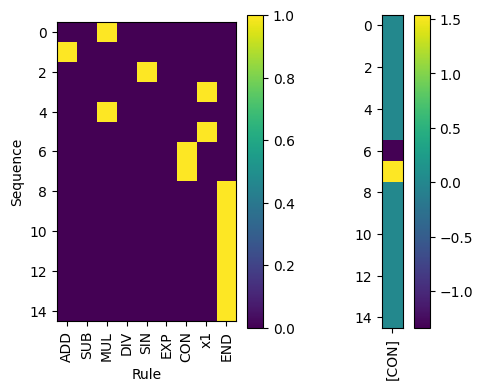

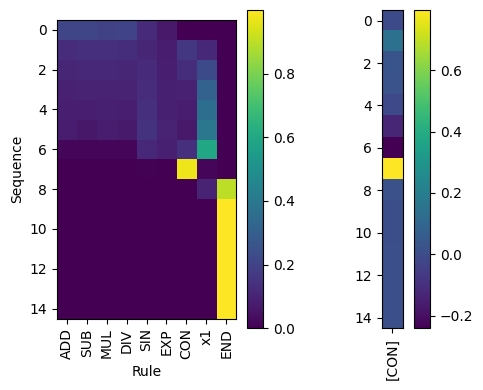

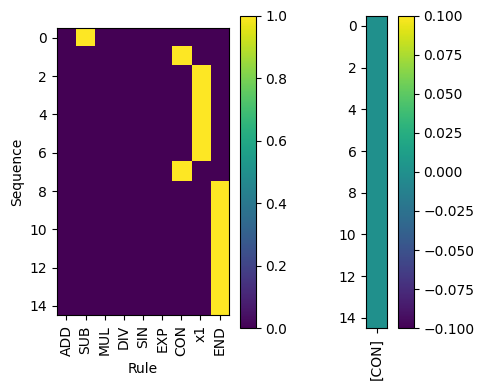

In [46]:
i = 4
x = data2input(data_syntax[i, ...])

logits, values_pred = vae_model.forward(x)

plot_onehot(x.squeeze(0).T.detach().numpy(), syntax_cats, figsize=(5, 4))
plot_onehot(logits.squeeze(0).detach().numpy(), syntax_cats, apply_softmax=True, figsize=(5, 4))


# Create a matrix where the argmax column is 1 and everything else is 0 for each row
logits_numpy = logits.squeeze(0).detach().numpy().copy()
argmax_matrix = np.zeros_like(logits_numpy)
argmax_indices = np.argmax(logits_numpy, axis=1)
argmax_matrix[np.arange(logits_numpy.shape[0]), argmax_indices] = 1

# Plot the argmax matrix
plot_onehot(argmax_matrix, syntax_cats, apply_softmax=False, figsize=(5, 4))

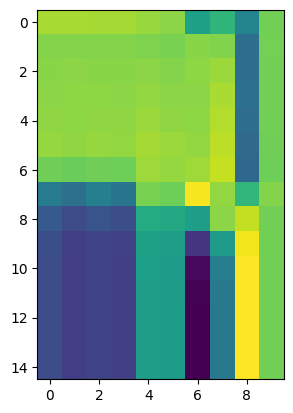

In [47]:
plt.imshow(logits.squeeze(0).detach().numpy())

In [98]:
from importlib import reload
import grammar
reload(util)
reload(grammar)
from util import logits_to_prods, prods_to_eq
from grammar import GCFG

prods = logits_to_prods(logits.squeeze(0), GCFG, sample=False)
print(prods)
eq = prods_to_eq(prods, verbose=True)
print(eq)


[S -> 'SUB' S S, S -> '0.15096333622932434', S -> 'x1']
['SUB', '0.15096333622932434', 'x1']


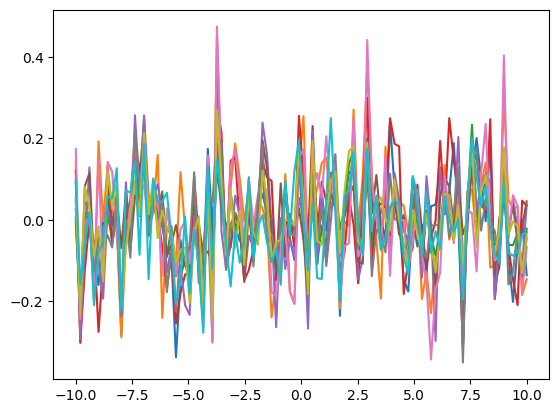

In [17]:
from matplotlib import pyplot as plt
import numpy as np

x = np.linspace(-10, 10, 100)

for _ in range(10):
    z = torch.randn(1, 10)
    res = vae_model.value_decoder.forward(z)
    plt.plot(x, res.squeeze().detach().numpy())
plt.show()

In [132]:
i = 3
eq = eqs[i]

expr = sp.simplify(sp.sympify(eq))
print(f'{eq = }; {expr = }')

x = data2input(data_syntax[i, ...])
mu, sigma = vae_model.encoder(x)
production = vae_model.generate(mu, sample=True, max_length=15)

print(f'{production = }')
eq_hat = prods_to_eq(production, verbose=True)
if eq_hat:
    expr_hat = sp.simplify(sp.sympify(eq_hat))
    print(f'{expr_hat = }')

eq = '(x1 + -0.39264077005823406) * 0.6814422896206572'; expr = 0.6814422896206572*x1 - 0.267562025346901
production = [S -> S '*' T, S -> T, T -> '(' S ')', S -> S '-' T, S -> T, T -> '-7.4198079109191895', T -> 'x1', T -> 'x1']
expr_hat = -x1*(x1 + 7.4198079109191895)


In [30]:
syntax_cats

['ADD', 'SUB', 'MUL', 'DIV', 'SIN', 'EXP', 'CON', 'x1', 'END']